In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 13 16:14:50 2019

@author: shyam
"""

from keras.models import Sequential,Model
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout,Input,Conv2D
import tensorflow as tf
import keras
import os
import cv2



Using TensorFlow backend.
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [3]:
S=64

#From Keras Documentation
from keras.preprocessing.image import ImageDataGenerator

trainDatagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

testDatagen = ImageDataGenerator(rescale=1./255)

trainDataset = trainDatagen.flow_from_directory(
        'E:/cat&dog/cat-and-dog/training_set/training_set',
        target_size=(S, S),
        batch_size=32,
        class_mode='binary')

testDataset = testDatagen.flow_from_directory(
        'E:/cat&dog/cat-and-dog/test_set/test_set',
        target_size=(S, S),
        batch_size=32,
        class_mode='binary')

Found 4405 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [4]:
label_dict = trainDatagen.flow_from_directory(
                    'E:/cat&dog/cat-and-dog/training_set/training_set',
                    target_size=(S, S),
                    ).class_indices

print(label_dict)

Found 4405 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [5]:
#Initializi
S=64
def classifier():
    
    classifier = Sequential()
        #Adding 1st Convolution Layer
    classifier.add(Convolution2D(filters=32, kernel_size=(3,3), strides=(1,1), input_shape=(S,S,3), activation='relu', padding='same'))

        #Adding 1st MaxPooling Layer to reduce the size of feature map
    classifier.add(MaxPooling2D(pool_size=(2,2), strides=(2,2) ))

        #Adding 1st BatchNormalization Layer for higher Learning Rate
    classifier.add(BatchNormalization())

        #Adding 1st Dropout Layer to eliminate overfitting
        #classifier.add(Dropout(0.2))

        #Adding 2nd Convolution Layer
    classifier.add(Convolution2D(filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

        #Adding 2nd MaxPooling Layer to reduce the size of feature map
    classifier.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #Adding 2nd BatchNormalization Layer for higher Learning Rate
    classifier.add(BatchNormalization())

        #Adding 2nd Dropout Layer to eliminate overfitting
    classifier.add(Dropout(0.2))

        #Adding Flatten Layer to convert 2D matrix into an array
    classifier.add(Flatten())

        #Adding Fully connected layer
    classifier.add(Dense(units=32,activation='relu'))

        #Adding Output Layer
    classifier.add(Dense(units=1,activation='sigmoid'))
    
    return classifier
 

In [6]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [7]:
def binary_focal_loss(gamma=2, alpha=0.25):
    """
    Binary form of focal loss.
    适用于二分类问题的focal loss
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(0.25, dtype=tf.float32)
    gamma = tf.constant(2, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

In [8]:
def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [9]:
classifier = classifier()
print(classifier.summary())









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 16)        64        
____________________

In [10]:
#Compiling the CNN
classifier.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[f1])


logdir = '.\callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"cat&dog_model2.h5")


#Fitting the CNN to images
history = classifier.fit_generator(trainDataset,
                         steps_per_epoch=4405,
                         epochs=2,
                         validation_data=testDataset,
                         validation_steps=2000,
                         verbose = 1,
                                  
                         callbacks = [
                                keras.callbacks.ModelCheckpoint(output_model_file)])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2
4405/4405 [==============================] - 584s 133ms/step - loss: 0.1729 - f1: 0.9651 - val_loss: 2.6746 - val_f1: 0.6886
Epoch 2/2
4405/4405 [==============================] - 544s 123ms/step - loss: 0.0583 - f1: 0.9875 - val_loss: 3.1915 - val_f1: 0.6916


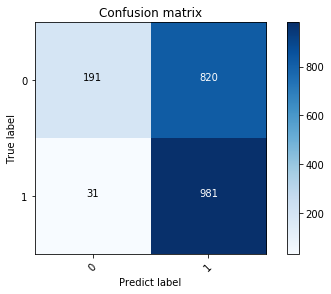

In [11]:
#混淆矩阵

def get_input_xy(src=[]):
    pre_x = []
    true_y = []

    class_indices = {'cat': 0, 'dog': 1}

    for s in src:
        input = cv2.imread(s)
        input = cv2.resize(input, (64, 64))
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        pre_x.append(input)

        _, fn = os.path.split(s)
        y = class_indices.get(fn[:3])
        true_y.append(y)

    pre_x = np.array(pre_x) / 255.0

    return pre_x, true_y


def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

dst_path = r'E:/cat&dog/cat-and-dog/test_set'
test_dir = os.path.join(dst_path, 'test_set')
test = os.listdir(test_dir)
images = []

# 获取每张图片的地址，并保存在列表images中
for testpath in test:
    for fn in os.listdir(os.path.join(test_dir, testpath)):
        if fn.endswith('jpg'):
            fd = os.path.join(test_dir, testpath, fn)
            images.append(fd)

# 得到规范化图片及true label
pre_x, true_y = get_input_xy(images)

# 预测
pred_y = classifier.predict_classes(pre_x)

# 画混淆矩阵
confusion_mat = confusion_matrix(true_y, pred_y)
plot_sonfusion_matrix(confusion_mat, classes=range(2))

<Figure size 432x288 with 0 Axes>

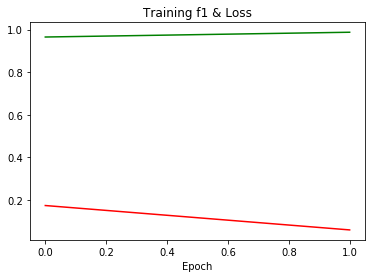

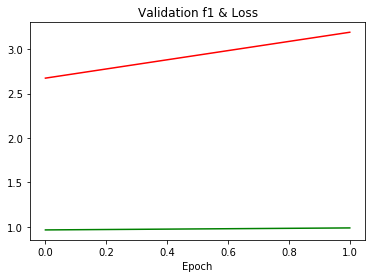

<Figure size 432x288 with 0 Axes>

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['f1'],'green',label='f1')
plt.plot(history.history['loss'],'red',label='Loss')
plt.title('Training f1 & Loss')
plt.xlabel('Epoch')
plt.figure()
plt.plot(history.history['f1'],'green',label='f1')
plt.plot(history.history['val_loss'],'red',label='Loss')
plt.title('Validation f1 & Loss')
plt.xlabel('Epoch')
plt.figure()

dog.4012.jpg
Probability that it is a Dog =  1.00


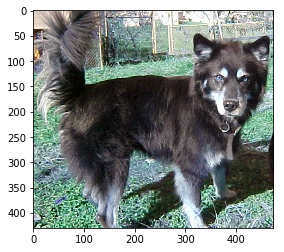

In [13]:

directory = os.listdir("E:/cat&dog/cat-and-dog/test_set/test_set/dogs" )
print(directory[11])

imgDog = cv2.imread("E:/cat&dog/cat-and-dog/test_set/test_set/dogs/" + directory[11])
plt.imshow(imgDog)

imgDog = cv2.resize(imgDog, (S,S))
imgDog = imgDog.reshape(1,S,S,3)

pred = classifier.predict(imgDog)
print("Probability that it is a Dog = ", "%.2f" % pred)